# Regularization of linear regression model

In this notebook, we explore some limitations of linear regression models and
demonstrate the benefits of using regularized models instead. Additionally, we
discuss the importance of scaling the data when working with regularized
models, especially when tuning the regularization parameter.

We start by highlighting the problem of overfitting that can occur with a
simple linear regression model.

## Effect of regularization

We load the Ames housing dataset. We retain some specific
`features_of_interest`.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/master/datasets/ames_housing_no_missing.csv"

ames_housing = pd.read_csv(url)
features_of_interest = [
    "LotFrontage",
    "LotArea",
    "PoolArea",
    "YearBuilt",
    "YrSold",
]
target_name = "SalePrice"
data, target = (
    ames_housing[features_of_interest],
    ames_housing[target_name],
)

In one of the previous notebooks, we showed that linear models could be used
even when there is no linear relationship between the `data` and `target`.
For instance, one can use the `PolynomialFeatures` transformer to create
additional features that capture some non-linear interactions between them.

Here, we use this transformer to augment the feature space. Subsequently, we
train a linear regression model. We use cross-validation with
`return_train_score=True` to evaluate both the train scores and the
generalization capabilities of our model.

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

linear_regression = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), LinearRegression()
).set_output(transform="pandas")
cv_results = cross_validate(
    linear_regression,
    data,
    target,
    cv=10,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    return_estimator=True,
)

We can compare the mean squared error on the training and testing set to
assess the generalization performance of our model.

In [3]:
train_error = -cv_results["train_score"]
print(
    "Mean squared error of linear regression model on the train set:\n"
    f"{train_error.mean():.2e} ± {train_error.std():.2e}"
)

Mean squared error of linear regression model on the train set:
2.85e+09 ± 8.68e+07


In [4]:
test_error = -cv_results["test_score"]
print(
    "Mean squared error of linear regression model on the test set:\n"
    f"{test_error.mean():.2e} ± {test_error.std():.2e}"
)

Mean squared error of linear regression model on the test set:
8.69e+10 ± 2.47e+11


The training error is in average one order of magnitude lower than the testing
error (lower error is better). Such a gap between the training and testing
scores is an indication that our model overfitted the training set. Indeed,
this is one of the dangers when augmenting the number of features with a
`PolynomialFeatures` transformer. For instance, one does not expect features
such as `PoolArea * YrSold` to be very predictive.

To analyze the weights of the model, we can create a dataframe. The columns of
the dataframe contain the feature names, while the rows store the coefficients
of each model of a given cross-validation fold.

In order to obtain the feature names associated with each feature combination,
we need to extract them from the augmented data created by
`PolynomialFeatures`. Fortunately, scikit-learn provides a convenient method
called `feature_names_in_` for this purpose. Let's begin by retrieving the
coefficients from the model fitted in the first cross-validation fold.

In [5]:
model_first_fold = cv_results["estimator"][0]
model_first_fold

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

Now, we can access the fitted `LinearRegression` (step `-1` i.e. the last step
of the `linear_regression` pipeline) to recover the feature names.

In [6]:
feature_names = model_first_fold[-1].feature_names_in_
feature_names

array(['LotFrontage', 'LotArea', 'PoolArea', 'YearBuilt', 'YrSold',
       'LotFrontage^2', 'LotFrontage LotArea', 'LotFrontage PoolArea',
       'LotFrontage YearBuilt', 'LotFrontage YrSold', 'LotArea^2',
       'LotArea PoolArea', 'LotArea YearBuilt', 'LotArea YrSold',
       'PoolArea^2', 'PoolArea YearBuilt', 'PoolArea YrSold',
       'YearBuilt^2', 'YearBuilt YrSold', 'YrSold^2'], dtype=object)

The following code creates a list by iterating through the estimators and
querying their last step for the learned `coef_`. We can then create the
dataframe containing all the information.

In [7]:
import pandas as pd

coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_linear_regression = pd.DataFrame(coefs, columns=feature_names)

Now, let's use a box plot to see the coefficients variations.

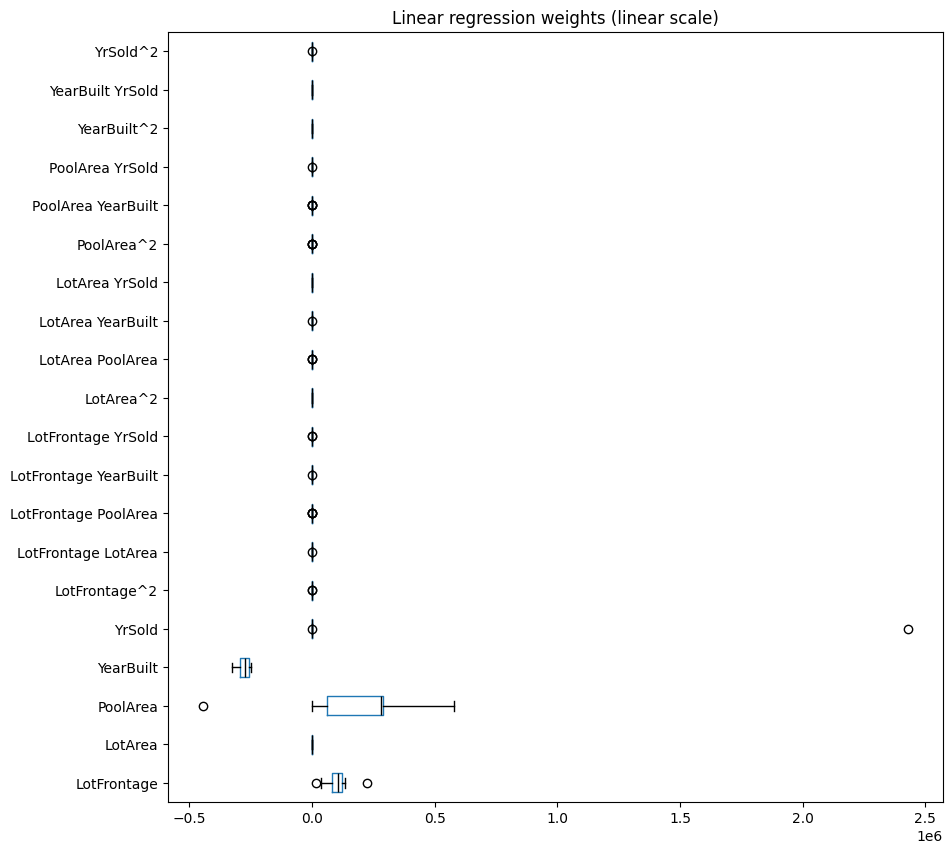

In [8]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
fig, ax = plt.subplots(figsize=(10, 10))
weights_linear_regression.plot.box(color=color, vert=False, ax=ax)
_ = ax.set(title="Linear regression weights (linear scale)")

By looking at the bar plot above it would seem that most of the features are
very close to zero, but this is just an effect of visualizing them on the same
scale as the extremely large span of `"YrSold"`. Instead we can use a
symmetric log scale for the plot.

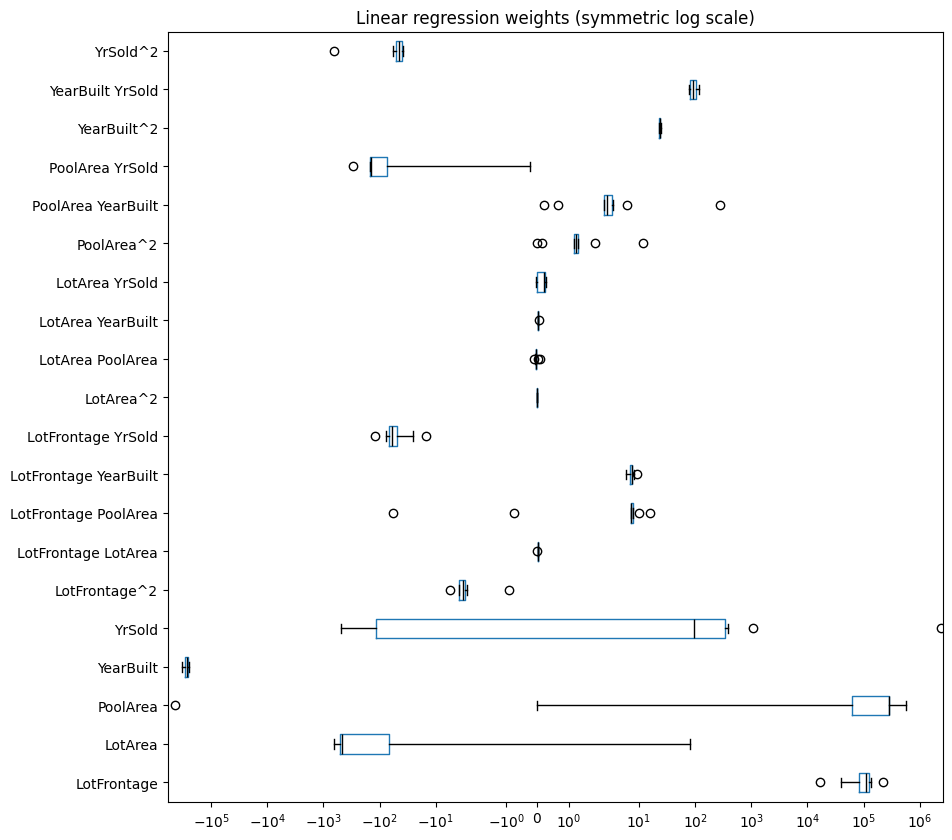

In [9]:
color = {"whiskers": "black", "medians": "black", "caps": "black"}
fig, ax = plt.subplots(figsize=(10, 10))
weights_linear_regression.plot.box(color=color, vert=False, ax=ax)
_ = ax.set(
    title="Linear regression weights (symmetric log scale)",
    xscale="symlog",
)

Observe that some coefficients are extremely large while others are extremely
small, yet non-zero. Furthermore, the coefficient values can be very unstable
across cross-validation folds.

We can force the linear regression model to consider all features in a more
homogeneous manner. In fact, we could force large positive or negative
weights to shrink toward zero. This is known as regularization. We use a
ridge model which enforces such behavior.

In [36]:
from sklearn.linear_model import Ridge
import warnings

warnings.filterwarnings(action='ignore', category=RuntimeWarning)

ridge = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    Ridge(alpha=100, solver="cholesky"),
)
cv_results = cross_validate(
    ridge,
    data,
    target,
    cv=20,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    return_estimator=True,
)

The code cell above can generate a couple of warnings (depending on the
choice of solver) because the features included both extremely large and
extremely small values, which are causing numerical problems when training
the predictive model. We will get to that in a bit.

Let us evaluate the train and test scores of this model.

In [11]:
train_error = -cv_results["train_score"]
print(
    "Mean squared error of ridge model on the train set:\n"
    f"{train_error.mean():.2e} ± {train_error.std():.2e}"
)

Mean squared error of ridge model on the train set:
2.90e+09 ± 6.56e+07


In [12]:
test_error = -cv_results["test_score"]
print(
    "Mean squared error of ridge model on the test set:\n"
    f"{test_error.mean():.2e} ± {test_error.std():.2e}"
)

Mean squared error of ridge model on the test set:
4.55e+10 ± 1.68e+11


We see that the training and testing scores get closer, indicating that our
model is less overfitting (yet still overfitting!). We can compare the values
of the weights of ridge with the un-regularized linear regression.

In [13]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

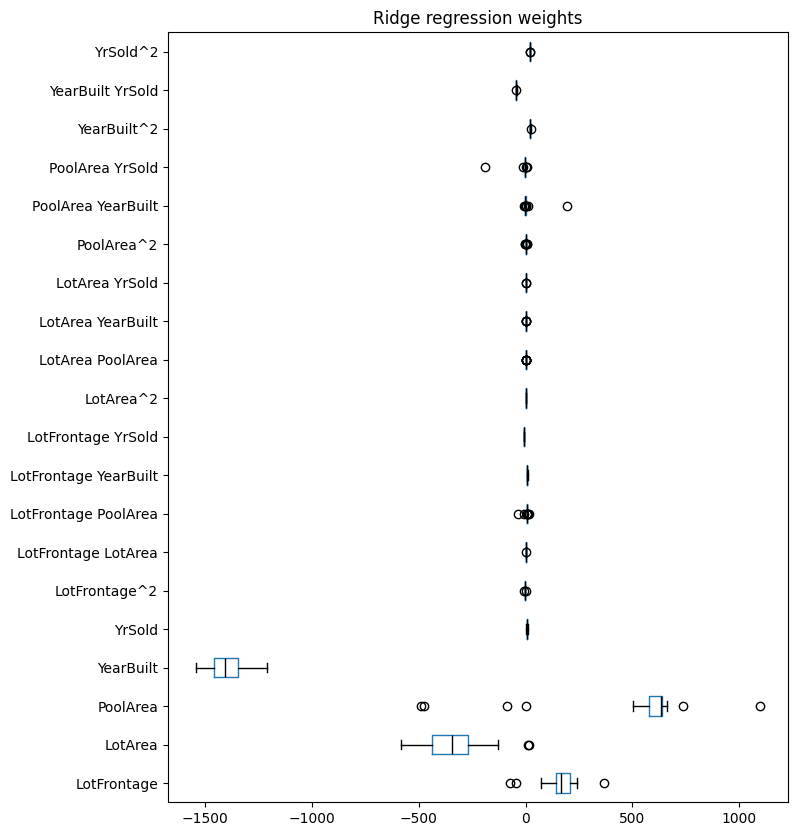

In [14]:
fig, ax = plt.subplots(figsize=(8, 10))
weights_ridge.plot.box(color=color, vert=False, ax=ax)
_ = ax.set(title="Ridge regression weights")

Notice that the overall magnitudes of the weights are shrunk
(yet non-zero!) with respect to the linear regression model. If you want to,
feel free to use a symmetric log scale in the previous plot.

You can also observe that even if the weights' values are less extreme, they
are still unstable from one fold to another. Even worst, the results can vary
a lot depending on the choice of the solver (for instance try to set
`solver="saga"` or `solver="lsqr"` instead of `solver="cholesky"` and re-run
the above cells).

In the following we attempt to resolve those remaining problems, by
focusing on two important aspects we omitted so far:
- the need to **scale the data**, and
- the need to **search for the best regularization parameter**.

## Feature scaling and regularization

On the one hand, weights define the association between feature values and the
predicted target, which depends on the scales of both the feature values and
the target. On the other hand, regularization adds constraints on the weights
of the model through the `alpha` parameter. Therefore, the effect that feature
rescaling has on the final weights also interacts with the use of
regularization.

Let's consider the case where features live on the same scale/units: if two
features are found to be equally important by the model, they are affected
similarly by the regularization strength.

Now, let's consider the scenario where two features have completely different
data scales (for instance age in years and annual revenue in dollars). Let's
also assume that both features are approximately equally predictive and are
not too correlated. Fitting a linear regression without scaling and without
regularization would give a higher weight to the feature with the smallest
natural scale. If we add regularization, the feature with the smallest natural
scale would be penalized more than the other feature. This is not desirable
given the hypothesis that both features are equally important. In such case we
require the regularization to stay neutral.

In practice, we don't know ahead of time which features are predictive, and
therefore we want regularization to treat all features approximately equally
by default. This can be achieved by rescaling the features.

Furthermore, many numerical solvers used internally in scikit-learn behave
better when features are approximately on the same scale. Heterogeneously
scaled data can be detrimental when solving for the optimal weights (hence the
warnings we tend to get when fitting linear models on raw data). Therefore,
when working with a linear model and numerical data, it is generally a good
practice to scale the data.

Thus, we add a `MinMaxScaler` in the machine learning pipeline, which scales
each feature individually such that its range maps into the range between zero
and one. We place it just before the `PolynomialFeatures` transformer as
powers of features in the range between zero and one remain in the same range.

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaled_ridge = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=2, include_bias=False),
    Ridge(alpha=10, solver="cholesky"),
)
cv_results = cross_validate(
    scaled_ridge,
    data,
    target,
    cv=10,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    return_estimator=True,
)

In [16]:
train_error = -cv_results["train_score"]
print(
    "Mean squared error of scaled ridge model on the train set:\n"
    f"{train_error.mean():.2e} ± {train_error.std():.2e}"
)

Mean squared error of scaled ridge model on the train set:
3.78e+09 ± 1.21e+08


In [17]:
test_error = -cv_results["test_score"]
print(
    "Mean squared error of scaled ridge model on the test set:\n"
    f"{test_error.mean():.2e} ± {test_error.std():.2e}"
)

Mean squared error of scaled ridge model on the test set:
3.83e+09 ± 1.17e+09


We observe that scaling data has a positive impact on the test error: it is
now both lower and closer to the train error. It means that our model is less
overfitted and that we are getting closer to the best generalization sweet
spot.

If you want to try different solvers, you can notice that fitting this
pipeline no longer generates any warning regardless of such choice.
Additionally, changing the solver should no longer result in significant
changes in the weights.

Let's have an additional look to the different weights.

In [18]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge_scaled_data = pd.DataFrame(coefs, columns=feature_names)

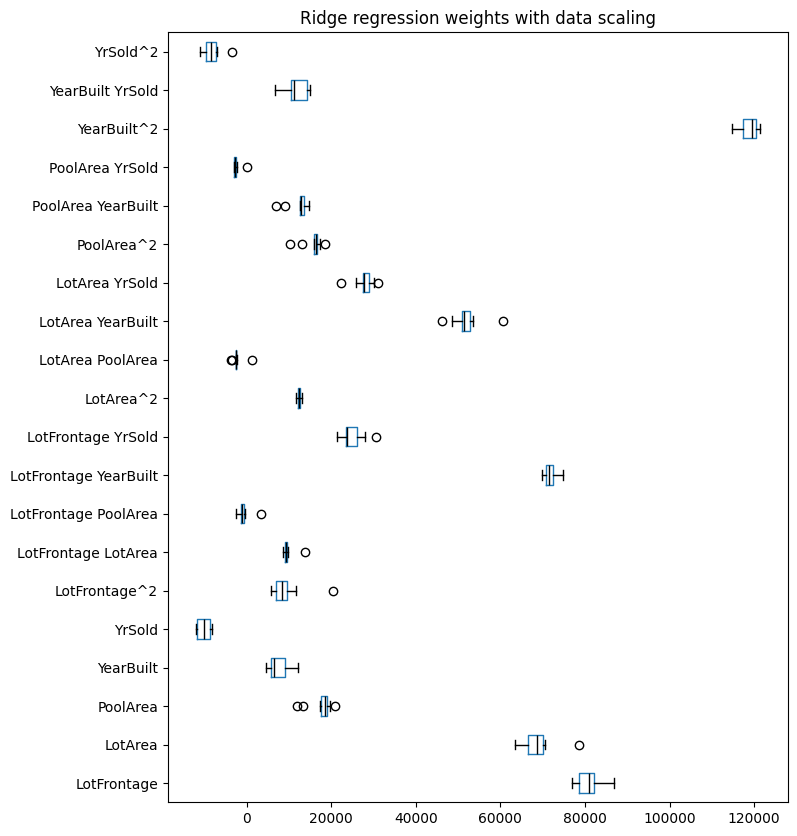

In [19]:
fig, ax = plt.subplots(figsize=(8, 10))
weights_ridge_scaled_data.plot.box(color=color, vert=False, ax=ax)
_ = ax.set(title="Ridge regression weights with data scaling")

Compared to the previous plots, we see that now most weight magnitudes have a
similar order of magnitude, i.e. they are more equally contributing. The
number of unstable weights also decreased.

In the previous model, we set `alpha=10`. We can now check the impact of
`alpha` by increasing it to a very large value.

In [20]:
ridge_large_alpha = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=2, include_bias=False),
    Ridge(alpha=1_000_000, solver="lsqr"),
)
cv_results = cross_validate(
    ridge_large_alpha,
    data,
    target,
    cv=10,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    return_estimator=True,
)

In [21]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge_scaled_data = pd.DataFrame(coefs, columns=feature_names)

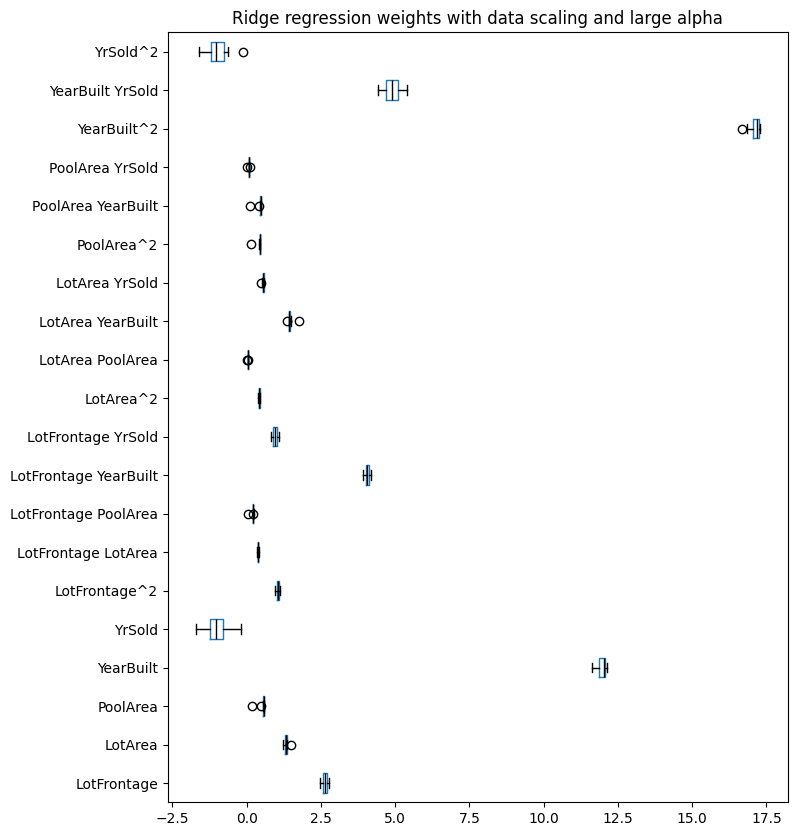

In [22]:
fig, ax = plt.subplots(figsize=(8, 10))
weights_ridge_scaled_data.plot.box(color=color, vert=False, ax=ax)
_ = ax.set(title="Ridge regression weights with data scaling and large alpha")

When examining the weight values, we notice that as the `alpha` value
increases, the weights decrease. A negative value of `alpha` can lead to
unpredictable and unstable behavior in the model.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p>Here, we only focus on numerical features. For categorical features, it is
generally common to omit scaling when features are encoded with a
<tt class="docutils literal">OneHotEncoder</tt> since the feature values are already on a similar scale.</p>
<p class="last">However, this choice may depend on the scaling method and the user case. For
instance, standard scaling categorical features that are imbalanced (e.g. more
occurrences of a specific category) would even out the impact of
regularization to each category. However, scaling such features in the
presence of rare categories could be problematic (i.e. division by a very
small standard deviation) and it can therefore introduce numerical issues.</p>
</div>

In the previous analysis, we chose the parameter beforehand and fixed it for
the analysis. In the next section, we check how the regularization parameter
`alpha` should be tuned.

## Tuning the regularization parameter

As mentioned, the regularization parameter needs to be tuned on each dataset.
The default parameter does not lead to the optimal model. Therefore, we need
to tune the `alpha` parameter.

Model hyperparameter tuning should be done with care. Indeed, we want to find
an optimal parameter that maximizes some metrics. Thus, it requires both a
training set and testing set.

However, this testing set should be different from the out-of-sample testing
set that we used to evaluate our model: if we use the same one, we are using
an `alpha` which was optimized for this testing set and it breaks the
out-of-sample rule.

Therefore, we should include search of the hyperparameter `alpha` within the
cross-validation. As we saw in previous notebooks, we could use a grid-search.
However, some predictor in scikit-learn are available with an integrated
hyperparameter search, more efficient than using a grid-search. The name of
these predictors finishes by `CV`. In the case of `Ridge`, scikit-learn
provides a `RidgeCV` regressor.

Cross-validating a pipeline that contains such predictors allows to make a
nested cross-validation: the inner cross-validation searches for the best
alpha, while the outer cross-validation gives an estimate of the testing
score.

In [23]:
import numpy as np
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-7, 5, num=100)
ridge = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=2, include_bias=False),
    RidgeCV(alphas=alphas, store_cv_values=True),
)

In [24]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=50, random_state=0)
cv_results = cross_validate(
    ridge,
    data,
    target,
    cv=cv,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    return_estimator=True,
    n_jobs=2,
)

In [25]:
train_error = -cv_results["train_score"]
print(
    "Mean squared error of tuned ridge model on the train set:\n"
    f"{train_error.mean():.2e} ± {train_error.std():.2e}"
)

Mean squared error of tuned ridge model on the train set:
3.12e+09 ± 1.25e+08


In [26]:
test_error = -cv_results["test_score"]
print(
    "Mean squared error of tuned ridge model on the test set:\n"
    f"{test_error.mean():.2e} ± {test_error.std():.2e}"
)

Mean squared error of tuned ridge model on the test set:
3.50e+09 ± 1.40e+09


By optimizing `alpha`, we see that the training and testing scores are close.
It indicates that our model is not overfitting.

When fitting the ridge regressor, we also requested to store the error found
during cross-validation (by setting the parameter `store_cv_values=True`). We
can plot the mean squared error for the different `alphas` regularization
strengths that we tried. The error bars represent one standard deviation of the
average mean square error across folds for a given value of `alpha`.

In [27]:
mse_alphas = [
    est[-1].cv_values_.mean(axis=0) for est in cv_results["estimator"]
]
cv_alphas = pd.DataFrame(mse_alphas, columns=alphas)
cv_alphas = cv_alphas.aggregate(["mean", "std"]).T
cv_alphas

c:\Users\npigeon1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


,mean,std
1.000000e-07,5.841881e+10,5.347783e+10
1.321941e-07,5.837563e+10,5.343115e+10
1.747528e-07,5.831866e+10,5.336956e+10
2.310130e-07,5.824352e+10,5.328835e+10
3.053856e-07,5.814452e+10,5.318133e+10
...,...,...
3.274549e+04,6.319038e+09,1.337394e+08
4.328761e+04,6.324503e+09,1.338181e+08
5.722368e+04,6.328652e+09,1.338778e+08
7.564633e+04,6.331799e+09,1.339232e+08


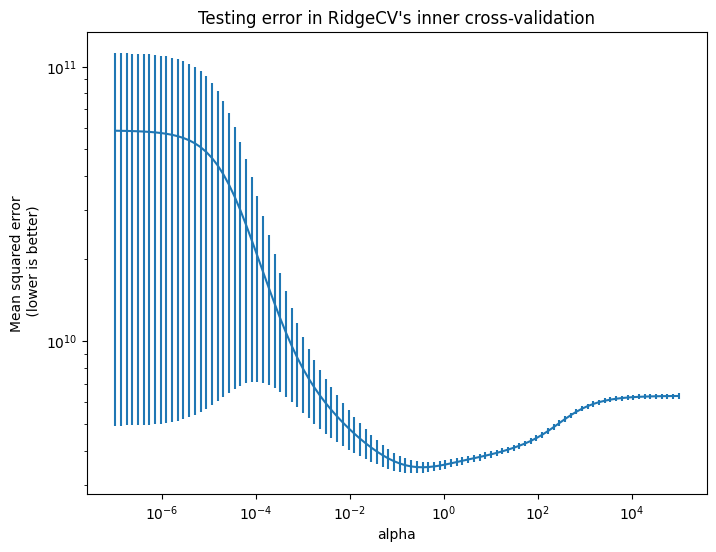

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(cv_alphas.index, cv_alphas["mean"], yerr=cv_alphas["std"])
_ = ax.set(
    xscale="log",
    xlabel="alpha",
    yscale="log",
    ylabel="Mean squared error\n (lower is better)",
    title="Testing error in RidgeCV's inner cross-validation",
)

As we can see, regularization is just like salt in cooking: one must balance
its amount to get the best generalization performance. We can check if the
best `alpha` found is stable across the cross-validation fold.

In [29]:
best_alphas = [est[-1].alpha_ for est in cv_results["estimator"]]
best_alphas

[np.float64(0.11497569953977356),
 np.float64(0.35111917342151344),
 np.float64(0.1519911082952933),
 np.float64(0.35111917342151344),
 np.float64(0.11497569953977356),
 np.float64(0.4641588833612782),
 np.float64(0.4641588833612782),
 np.float64(0.4641588833612782),
 np.float64(0.4641588833612782),
 np.float64(0.35111917342151344),
 np.float64(0.35111917342151344),
 np.float64(0.4641588833612782),
 np.float64(0.11497569953977356),
 np.float64(0.11497569953977356),
 np.float64(0.35111917342151344),
 np.float64(0.4641588833612782),
 np.float64(0.11497569953977356),
 np.float64(0.35111917342151344),
 np.float64(0.35111917342151344),
 np.float64(0.35111917342151344),
 np.float64(0.35111917342151344),
 np.float64(0.4641588833612782),
 np.float64(0.35111917342151344),
 np.float64(0.4641588833612782),
 np.float64(0.35111917342151344),
 np.float64(0.35111917342151344),
 np.float64(0.35111917342151344),
 np.float64(0.08697490026177834),
 np.float64(0.6135907273413176),
 np.float64(0.4641588833

The optimal regularization strength is not necessarily the same on all
cross-validation iterations. But since we expect each cross-validation
resampling to stem from the same data distribution, it is common practice to
choose the best `alpha` to put into production as lying in the range defined
by:

In [30]:
print(
    f"Min optimal alpha: {np.min(best_alphas):.2f} and "
    f"Max optimal alpha: {np.max(best_alphas):.2f}"
)

Min optimal alpha: 0.09 and Max optimal alpha: 0.61


This range can be reduced depending on the feature engineering and
preprocessing.

Here is a summary of important points highlighted in this notebook:
- scaling features makes the effect of regularization more even: all variables
  are regularized by comparable magnitude, which would not necessarily be the
  case with the natural feature scales;
- scaling features makes the numerical solvers more stable which is also
  helpful to tune the regularization parameter more independently of the
  choice of the solver used to fit the linear model;
- tuning the regularization parameter of the `Ridge` estimator can be done
  very efficiently by using the `RidgeCV` class. Wrapping it into a
  `cross_validate` call makes it possible to assess the true generalization
  power of the whole pipeline by including the tuning of the regularization
  parameter as part of the learning process: this is an example of "nested
  cross-validation";
- doing so makes it possible to check that the optimal value of the
  regularization strength `alpha` is robust to a resampling of the dataset. If
  it wasn't the case it would hint at a problem with the dataset (e.g.
  presence of outliers in the features or the target that influence the
  learning process disproportionately) or a bad choice of other elements of
  the feature engineering pipeline.